c:\Users\eisra\miniconda3\envs\wif3009\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading and preparing data...


C:\Users\eisra\AppData\Local\Temp\ipykernel_17628\4044334190.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[text_feature] = df[text_feature]



Training Logistic Regression...
3-Fold ROC-AUC: 0.999 (±0.001)

Training Random Forest...
3-Fold ROC-AUC: 0.995 (±0.001)

Training Neural Network...
3-Fold ROC-AUC: 0.997 (±0.001)

Training Decision Tree...
3-Fold ROC-AUC: 0.984 (±0.016)

Best Model: Logistic Regression (ROC-AUC: 0.999)

Performing time-series analysis...


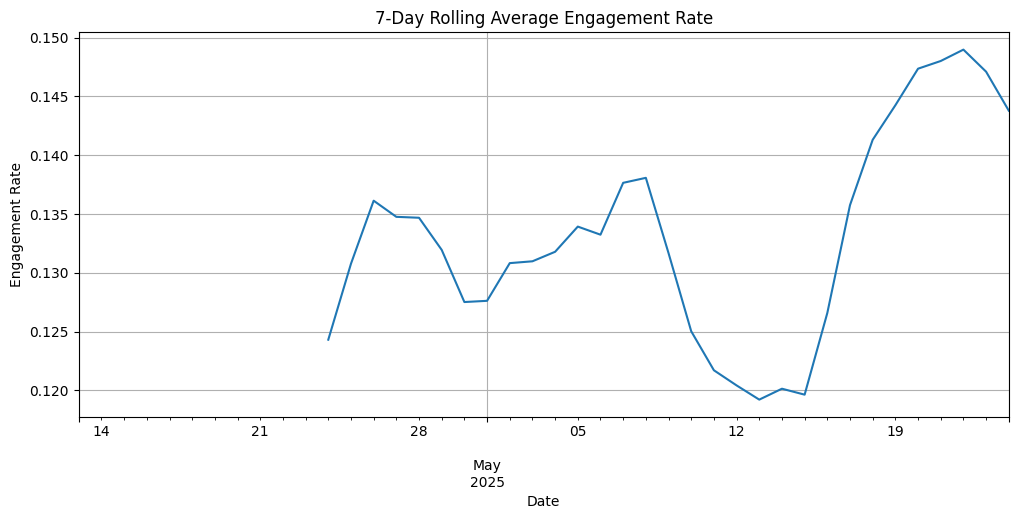


Running ARIMA forecast...


c:\Users\eisra\miniconda3\envs\wif3009\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\eisra\miniconda3\envs\wif3009\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\eisra\miniconda3\envs\wif3009\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\eisra\miniconda3\envs\wif3009\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

                                  SARIMAX Results                                   
Dep. Variable:     engagement_rate_per_play   No. Observations:                   40
Model:                       ARIMA(7, 1, 2)   Log Likelihood                  80.954
Date:                      Sun, 01 Jun 2025   AIC                           -141.908
Time:                              22:50:01   BIC                           -125.273
Sample:                                   0   HQIC                          -135.940
                                       - 40                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6395      0.949     -0.674      0.500      -2.499       1.220
ar.L2         -0.1364      0.521     -0.262      0.793      -1.157       0.885
ar.L

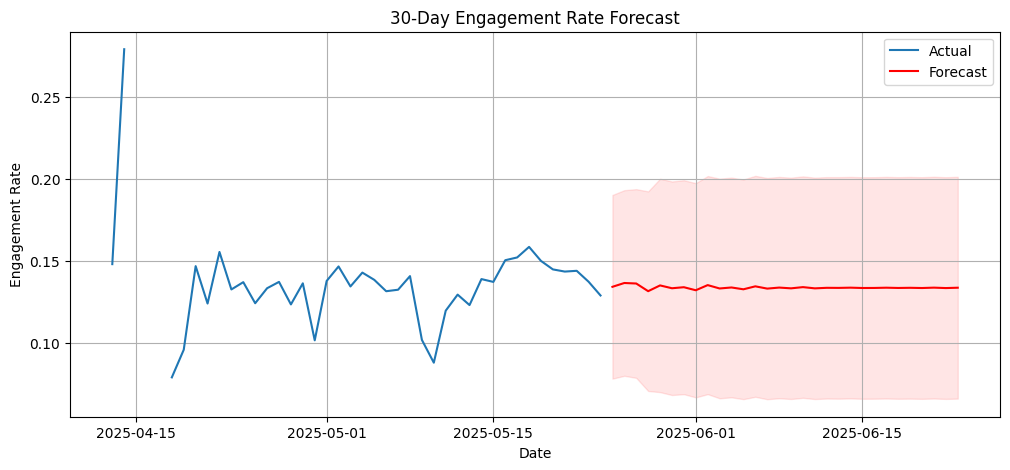

In [1]:
# ======================
# TIKTOK TREND PREDICTION (CLEANED VERSION)
# ======================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier  
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
from statsmodels.tsa.arima.model import ARIMA

# ======================
# DATA LOADING & CLEANING
# ======================

print("Loading and preparing data...")
df = pd.read_csv('data/processed/tiktok_processed.csv')

# Handle text data
df['clean_description'] = df['clean_description'].fillna('').astype(str)

# Create target variable
df['is_trending'] = (df['engagement_rate_per_play'] > 0.35).astype(int)

# Create normalized engagement metrics
df['likes_per_play'] = df['likes'] / (df['plays'] + 1e-6)
df['comments_per_play'] = df['comments'] / (df['plays'] + 1e-6)
df['shares_per_play'] = df['shares'] / (df['plays'] + 1e-6)

# Group rare authors
author_counts = df['author'].value_counts()
rare_authors = author_counts[author_counts < 10].index
df['author'] = df['author'].replace(rare_authors, 'other')

# ======================
# FEATURE DEFINITION
# ======================

numerical_features = [
    'create_hour', 'likes_per_play', 'comments_per_play',
    'shares_per_play', 'viral_coefficient_norm',
    'hashtag_count', 'description_length', 'sentiment_polarity'
]

categorical_features = [
    'day_of_week', 'is_weekend', 'time_period', 'author'
]

text_feature = 'clean_description'

# Optional: Set to False to test without text
use_text_feature = True

# ======================
# PREPROCESSING PIPELINE
# ======================

transformers = [
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
]

if use_text_feature:
    transformers.append((
        'text',
        TfidfVectorizer(
            max_features=100,
            ngram_range=(1, 2),
            stop_words='english',
            min_df=5,
            max_df=0.8
        ),
        text_feature
    ))

preprocessor = ColumnTransformer(transformers)

# ======================
# MODEL DEFINITIONS
# ======================

models = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        C=0.1,
        solver='saga'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=7,
        min_samples_leaf=5,
        class_weight='balanced',
        n_jobs=-1
    ),
    'Neural Network': MLPClassifier(
        hidden_layer_sizes=(64, 32),
        alpha=0.01,
        early_stopping=True,
        max_iter=500
    ),
    'Decision Tree': DecisionTreeClassifier(        
        max_depth=5,
        min_samples_leaf=10,
        class_weight='balanced',
        random_state=42
    )
}

# ======================
# MODEL TRAINING
# ======================

X = df[numerical_features + categorical_features]
if use_text_feature:
    X[text_feature] = df[text_feature]
y = df['is_trending']

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    pipeline = ImbPipeline([
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    cv_scores = cross_val_score(
        pipeline, X, y,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1
    )

    pipeline.fit(X, y)

    results[name] = {
        'model': pipeline,
        'cv_roc_auc': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }

    print(f"3-Fold ROC-AUC: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

# ======================
# MODEL ANALYSIS
# ======================

best_model_name = max(results, key=lambda k: results[k]['cv_roc_auc'])
best_model = results[best_model_name]['model']
print(f"\nBest Model: {best_model_name} (ROC-AUC: {results[best_model_name]['cv_roc_auc']:.3f})")

# Feature Importance + SHAP (Only if Random Forest is best)
if best_model_name == 'Random Forest':
    print("\nExtracting feature importance...")
    rf_model = best_model.named_steps['model']
    preprocess_step = best_model.named_steps['preprocess']

    # Get feature names
    feature_names = numerical_features
    cat_names = preprocess_step.named_transformers_['cat'].get_feature_names_out(categorical_features)
    feature_names += list(cat_names)

    if use_text_feature:
        feature_names += [f"text_{i}" for i in range(100)]

    importances = pd.Series(rf_model.feature_importances_, index=feature_names)
    top_features = importances.sort_values(ascending=False).head(20)

    plt.figure(figsize=(10, 6))
    top_features.plot.barh()
    plt.title("Top 20 Important Features")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()

    print("\nRunning SHAP analysis...")
    X_processed = preprocess_step.transform(X)
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_processed[:1000])
    shap.summary_plot(shap_values[1], X_processed[:1000], feature_names=feature_names, plot_type="bar")

# ======================
# TIME-SERIES ANALYSIS
# ======================

print("\nPerforming time-series analysis...")
df['create_time'] = pd.to_datetime(df['create_time'])
daily_engagement = df.set_index('create_time')['engagement_rate_per_play'].resample('D').mean()

# Plot 7-day rolling average
plt.figure(figsize=(12, 5))
daily_engagement.rolling(7).mean().plot(
    title="7-Day Rolling Average Engagement Rate",
    xlabel="Date",
    ylabel="Engagement Rate"
)
plt.grid(True)
plt.show()

# ARIMA Forecasting
print("\nRunning ARIMA forecast...")
model = ARIMA(daily_engagement.dropna(), order=(7, 1, 2), seasonal_order=(0, 0, 0, 7))
arima_results = model.fit()
print(arima_results.summary())

# Forecast next 30 days 
forecast_obj = arima_results.get_forecast(steps=30)
forecast_df = forecast_obj.conf_int(alpha=0.05)
forecast_df['mean'] = forecast_obj.predicted_mean.values

# Fix forecast index for 30 days ahead
last_date = daily_engagement.dropna().index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
forecast_df.index = forecast_index

# Plot
plt.figure(figsize=(12, 5))
plt.plot(daily_engagement, label='Actual')
plt.plot(forecast_df['mean'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, forecast_df.iloc[:, 0], forecast_df.iloc[:, 1], color='red', alpha=0.1)
plt.title("30-Day Engagement Rate Forecast")
plt.xlabel("Date")
plt.ylabel("Engagement Rate")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay


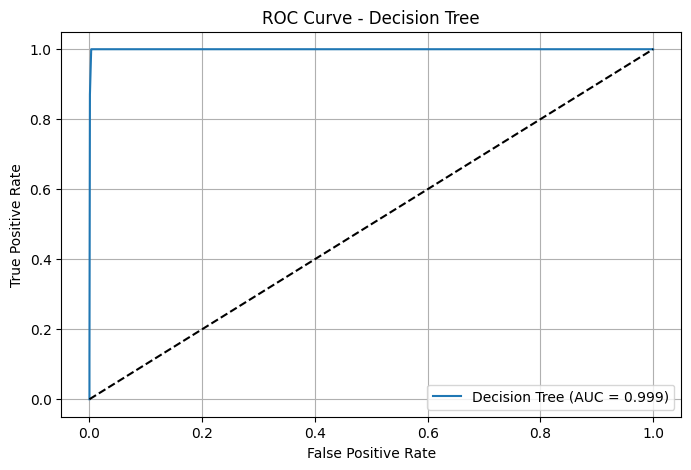

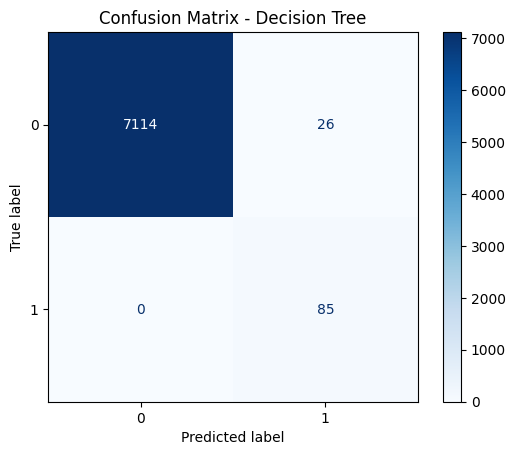

In [20]:
from matplotlib import pyplot as plt

# Predict probabilities and labels
y_pred_proba = pipeline.predict_proba(X)[:, 1]
y_pred = pipeline.predict(X)

# ROC curve
fpr, tpr, _ = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {name}')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Confusion matrix
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - {name}')
plt.show()
